In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import xgboost as xgb
from datetime import date
from statsmodels.stats.weightstats import ttest_ind
from scipy.stats import skew
from scipy import stats
from sklearn.preprocessing import power_transform

from matplotlib import pyplot as plt
import utility 

# House prediction 

In [2]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
col = ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b-100','lstat']
df = pd.DataFrame(X,columns=col)
df['med_v'] = y

df = df.sample(300)


scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop('med_v',axis=1), df_input_scale['med_v'], test_size=0.2, random_state=42)

rf_house = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, rf_house, name='rf', verbose =1 )

df_residual_rf = pd.DataFrame()
df_residual_rf['target'] = y_test
df_residual_rf['pred'] = y_pred_test_regr
df_residual_rf['error'] = df_residual_rf['target'] - df_residual_rf['pred']
df_residual_rf['std_error'] = (df_residual_rf['error'] - df_residual_rf['error'].mean()) / df_residual_rf['error'].std()


NameError: name 'model_perform' is not defined

## Statiscial regression analysis 

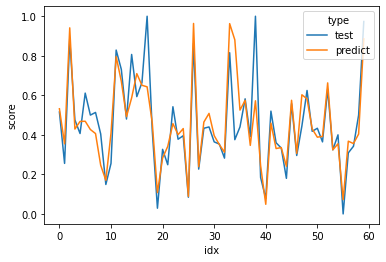

In [44]:
# show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

[Text(0.5, 1.0, 'coreelation between error and predicted -0.11039968152479')]

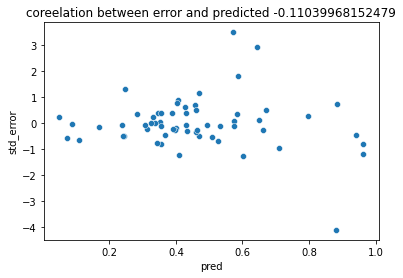

In [45]:
# examine predicted vs residual 
corr = stats.pearsonr(df_residual_rf['pred'],df_residual_rf['std_error'])[0]
sns.scatterplot(data=df_residual_rf, x="pred", y="std_error").set(title='coreelation between error and predicted {}'.format(corr)) 

[Text(0.5, 1.0, 'coreelation between actual and predicted 0.8509668126036336')]

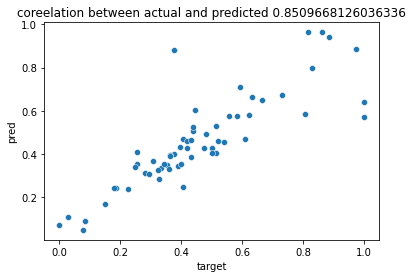

In [46]:
# correlation 
corr = stats.pearsonr(df_residual_rf['target'],df_residual_rf['pred'])[0]
sns.scatterplot(data=df_residual_rf, x="target", y="pred").set(title='coreelation between actual and predicted {}'.format(corr)) 

<AxesSubplot:title={'center':'error skewness from random forest 0.027'}, ylabel='Frequency'>

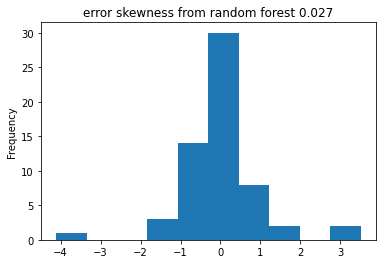

In [47]:
# plot error skewness 
title = 'error skewness from random forest {}'.format(np.round(skew(df_residual_rf['std_error']),3))
df_residual_rf['std_error'].plot(kind='hist', title = title)

# Zomato Error analysis 

In [2]:
# zomato only
df_zom_train = pd.read_csv('data/3_clean_zomato_feat_ori_train.csv')
df_zom_train['rest_price_idr'] = df_zom_train['rest_price_idr'].astype(int)
df_zom_train = df_zom_train[df_zom_train['rating']>0]


df_zom_test = pd.read_csv('data/3_clean_zomato_feat_ori_test.csv')
df_zom_test['rest_price_idr'] = df_zom_test['rest_price_idr'].astype(int)
df_zom_test = df_zom_test[df_zom_test['rating']>0]

# filter chain and non chain 
# df_zom_train = df_zom_train[df_zom_train['is_chain']==0]
# df_zom_test = df_zom_test[df_zom_test['is_chain']==0]

# df_zom = pd.read_csv('data/3_jbdk_clean_zomato_feat.csv')

# ori 
drop_column = ['url','index','rating','lat','long','review']
target_column = 'rating'

# best param
rf_param = {'n_estimators':500,'max_features':3, 'max_depth':30,'bootstrap':True}
xgb_param = {'n_estimators':100, 'max_depth':5, 'min_child_weight':3, 'learning_rate':0.15, 'booster':'gbtree'}
svr_param  = {'kernel':'poly','gamma':0.1,'C':0.1}


# scaled the values 
features_columns = df_zom_train.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

df_input_train_scale = pd.DataFrame(scaler_train.fit_transform(df_zom_train[features_columns]), columns = features_columns)
df_input_test_scale = pd.DataFrame(scaler_test.fit_transform(df_zom_test[features_columns]), columns = features_columns)

# Prediction 

result_zomato = []

# Random Forest 
regr = RandomForestRegressor(**rf_param)
model_regr, y_pred_test_regr, y_pred_train_regr, result_regr = utility.model_perform(df_input_train_scale.drop(target_column,axis=1),  df_input_train_scale[target_column],  df_input_test_scale.drop(target_column,axis=1),  df_input_test_scale[target_column],  regr, name = 'rf', verbose = 0 )
result_zomato.append(result_regr)

# xgb 
xgbr = XGBRegressor(**xgb_param)
model_xgb, y_pred_test_xgb, y_pred_train_xgb, result_xgb = utility.model_perform(df_input_train_scale.drop(target_column,axis=1), df_input_train_scale[target_column], df_input_test_scale.drop(target_column,axis=1), df_input_test_scale[target_column], xgbr, name = 'xgb', verbose = 0 )
result_zomato.append(result_xgb)

# svr 
svr = SVR(**svr_param)
model_svr, y_pred_test_svr, y_pred_train_svr, result_svr = utility.model_perform(df_input_train_scale.drop(target_column, axis=1), df_input_train_scale[target_column], df_input_test_scale.drop(target_column,axis=1), df_input_test_scale[target_column], svr, name = 'svr', verbose = 0 )
result_zomato.append(result_svr)

df_result_zomato = pd.DataFrame(result_zomato)
df_result_zomato['dataset'] = 'zomato'

# store regression output 

df_zom_scat_reg = pd.DataFrame()
df_zom_scat_reg['y_act'] = df_input_test_scale[target_column]
df_zom_scat_reg['y_pred_rf'] = y_pred_test_regr
df_zom_scat_reg['y_pred_svr'] = y_pred_test_svr
df_zom_scat_reg['y_pred_xgb'] = y_pred_test_xgb
df_zom_scat_reg['error_rf'] = df_zom_scat_reg['y_act'] - df_zom_scat_reg['y_pred_rf']
df_zom_scat_reg['std_error_rf'] = (df_zom_scat_reg['error_rf'] - df_zom_scat_reg['error_rf'].mean()) / df_zom_scat_reg['error_rf'].std()
df_zom_scat_reg['error_svr'] = df_zom_scat_reg['y_act'] - df_zom_scat_reg['y_pred_svr']
df_zom_scat_reg['std_error_svr'] = (df_zom_scat_reg['error_svr'] - df_zom_scat_reg['error_svr'].mean()) / df_zom_scat_reg['error_svr'].std()
df_zom_scat_reg['error_xgb'] = df_zom_scat_reg['y_act'] - df_zom_scat_reg['y_pred_xgb']
df_zom_scat_reg['std_error_xgb'] = (df_zom_scat_reg['error_xgb'] - df_zom_scat_reg['error_xgb'].mean()) / df_zom_scat_reg['error_xgb'].std()

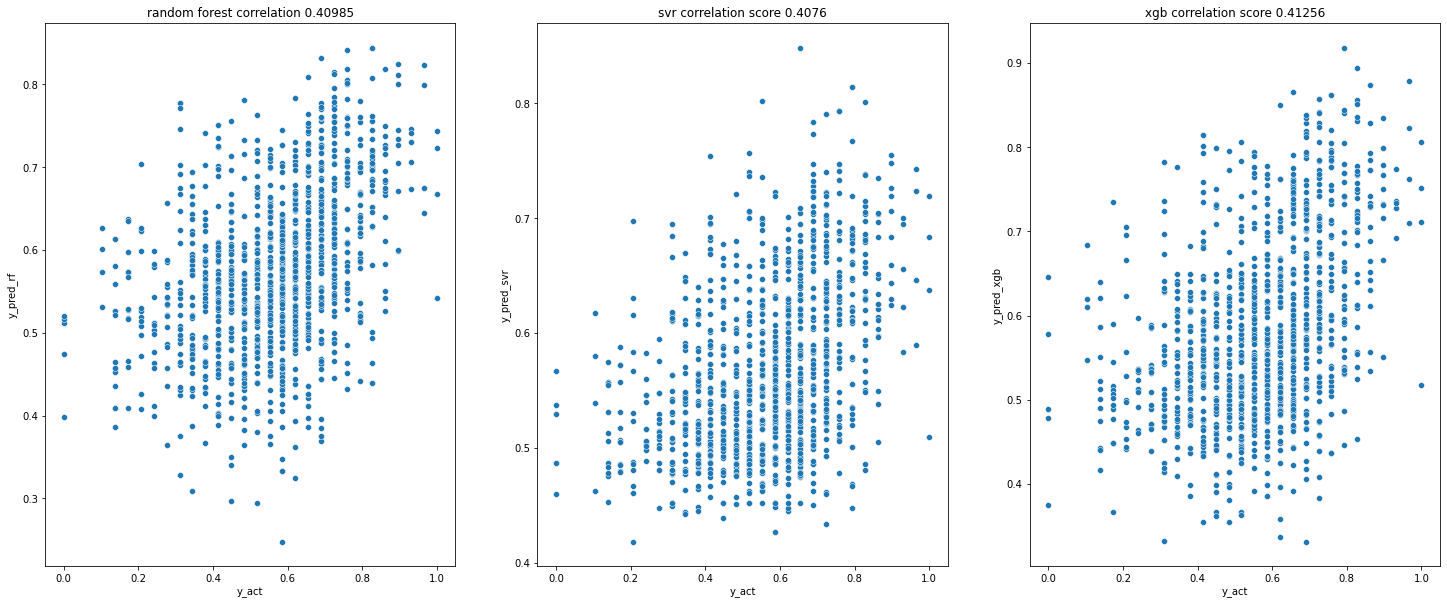

In [4]:
# correlation 

fig, ax = plt.subplots(1, 3, figsize=(25,10))

corr = stats.pearsonr(df_zom_scat_reg['y_act'],df_zom_scat_reg['y_pred_rf'])[0]
sns.scatterplot(data=df_zom_scat_reg, x="y_act", y="y_pred_rf", ax=ax[0]).set(title='random forest correlation {}'.format(round(corr,5))) 

corr = stats.pearsonr(df_zom_scat_reg['y_act'],df_zom_scat_reg['y_pred_svr'])[0]
sns.scatterplot(data=df_zom_scat_reg, x="y_act", y="y_pred_svr", ax=ax[1]).set(title='svr correlation score {}'.format(round(corr,5))) 

corr = stats.pearsonr(df_zom_scat_reg['y_act'],df_zom_scat_reg['y_pred_xgb'])[0]
sns.scatterplot(data=df_zom_scat_reg, x="y_act", y="y_pred_xgb", ax=ax[2]).set(title='xgb correlation score {}'.format(round(corr,5))) 

plt.show()

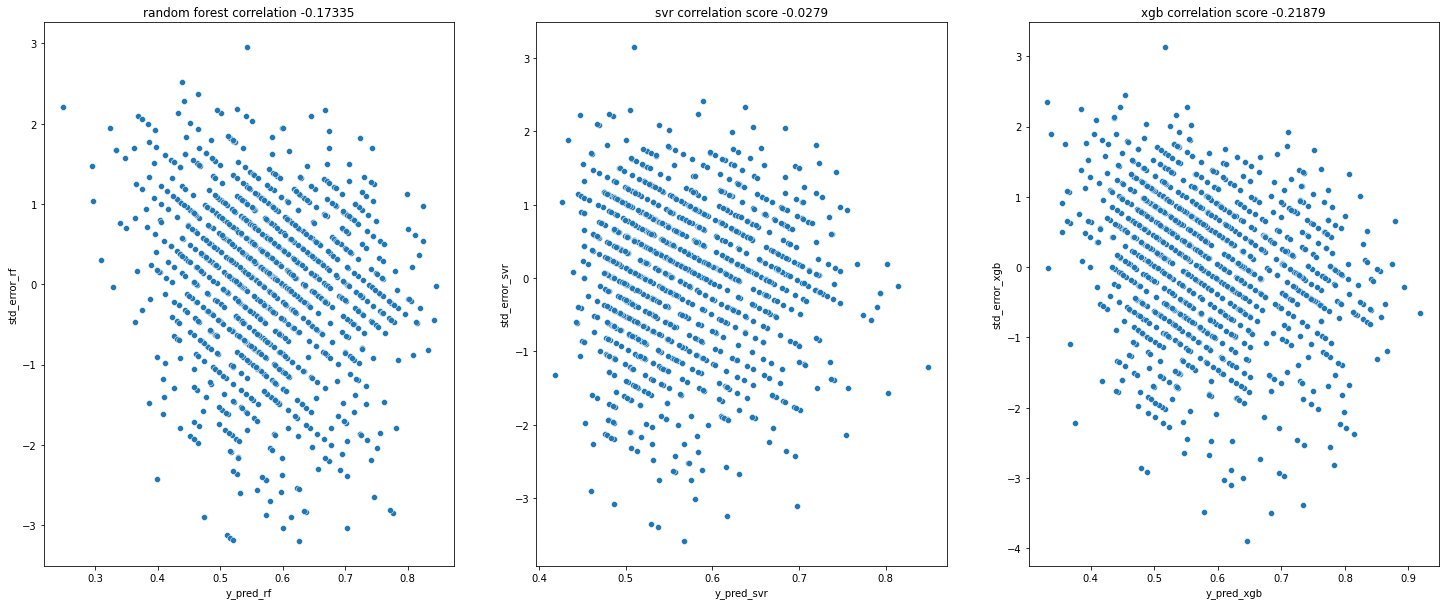

In [5]:
# examine predicted vs residual 

fig, ax = plt.subplots(1, 3, figsize=(25,10))

corr = stats.pearsonr(df_zom_scat_reg['std_error_rf'],df_zom_scat_reg['y_pred_rf'])[0]
sns.scatterplot(data=df_zom_scat_reg, x="y_pred_rf", y="std_error_rf", ax=ax[0]).set(title='random forest correlation {}'.format(round(corr,5))) 

corr = stats.pearsonr(df_zom_scat_reg['std_error_svr'],df_zom_scat_reg['y_pred_svr'])[0]
sns.scatterplot(data=df_zom_scat_reg, x="y_pred_svr", y="std_error_svr", ax=ax[1]).set(title='svr correlation score {}'.format(round(corr,5))) 

corr = stats.pearsonr(df_zom_scat_reg['std_error_xgb'],df_zom_scat_reg['y_pred_xgb'])[0]
sns.scatterplot(data=df_zom_scat_reg, x="y_pred_xgb", y="std_error_xgb", ax=ax[2]).set(title='xgb correlation score {}'.format(round(corr,5))) 

plt.show()

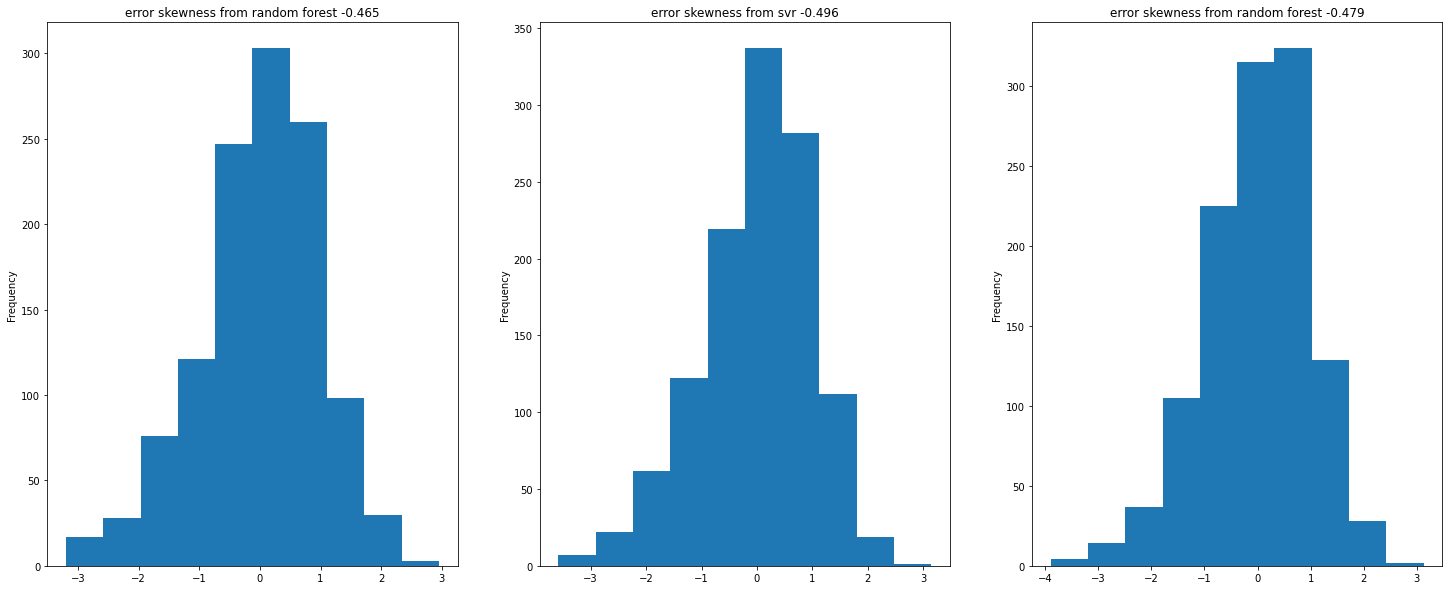

In [6]:
# Error distribution  

fig, ax = plt.subplots(1, 3, figsize=(25,10))

title = 'error skewness from random forest {}'.format(np.round(skew(df_zom_scat_reg['std_error_rf']),3))
df_zom_scat_reg['std_error_rf'].plot(kind='hist', title = title, ax = ax[0]) 

title = 'error skewness from svr {}'.format(np.round(skew(df_zom_scat_reg['std_error_svr']),3))
df_zom_scat_reg['std_error_svr'].plot(kind='hist', title = title, ax = ax[1]) 

title = 'error skewness from random forest {}'.format(np.round(skew(df_zom_scat_reg['std_error_xgb']),3))
df_zom_scat_reg['std_error_xgb'].plot(kind='hist', title = title, ax = ax[2]) 
plt.show()


# plot error skewness 


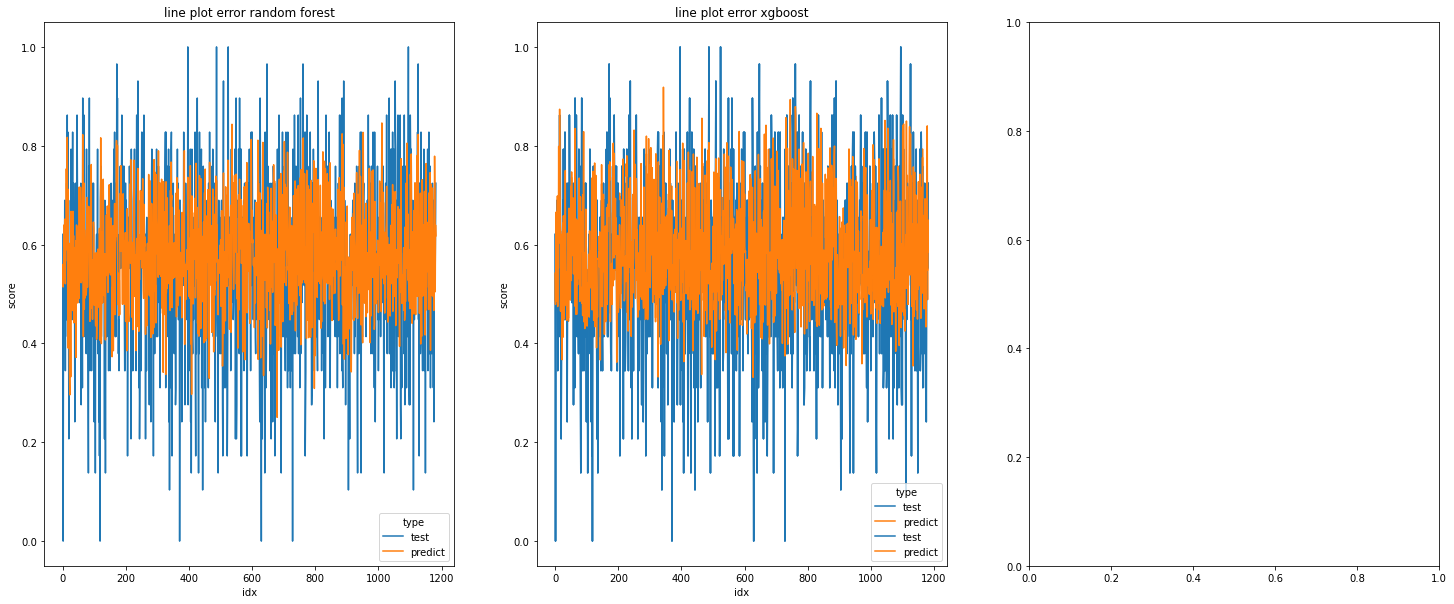

In [6]:
# line plot actual vs pred 

fig, ax = plt.subplots(1, 3, figsize=(25,10))

title = 'line plot error random forest'
utility.show_error_pattern(y_pred =  df_zom_scat_reg['y_pred_rf'] , y_test= df_zom_scat_reg['y_act'] , ax = ax[0], title = title)

# title = 'line plot error randomm svr {}'.format(np.round(skew(df_zom_scat_reg['std_error_svr']),3))
# df_zom_scat_reg['std_error_svr'].plot(kind='hist', title = title, ax = ax[1]) 

title = 'line plot error svr'
utility.show_error_pattern(y_pred =  df_zom_scat_reg['y_pred_svr'] , y_test= df_zom_scat_reg['y_act'] , ax = ax[1], title = title)


title = 'line plot error xgboost'
utility.show_error_pattern(y_pred =  df_zom_scat_reg['y_pred_xgb'] , y_test= df_zom_scat_reg['y_act'] , ax = ax[2], title = title)

plt.show()



In [35]:
df_zom_scat_reg

,y_act,y_pred_rf,y_pred_svr,y_pred_xgb,error_rf,std_error_rf,error_svr,std_error_svr,error_xgb,std_error_xgb
0,0.620690,0.550146,0.540258,0.542272,0.070543,0.525490,0.080432,0.536795,0.078417,0.611933
1,0.000000,0.515735,0.486398,0.478849,-0.515735,-3.152280,-0.486398,-3.071333,-0.478849,-2.859201
2,0.448276,0.527729,0.532516,0.558313,-0.079453,-0.415448,-0.084240,-0.511415,-0.110037,-0.561924
3,0.586207,0.574138,0.553135,0.665802,0.012069,0.158676,0.033072,0.235328,-0.079595,-0.372301
4,0.586207,0.626177,0.563230,0.614489,-0.039971,-0.167772,0.022977,0.171070,-0.028283,-0.052685
...,...,...,...,...,...,...,...,...,...,...
1178,0.724138,0.774745,0.610616,0.626067,-0.050607,-0.234497,0.113522,0.747428,0.098071,0.734353
1179,0.724138,0.684883,0.603077,0.840162,0.039255,0.329218,0.121061,0.795420,-0.116024,-0.599211
1180,0.551724,0.500463,0.488544,0.547866,0.051261,0.404532,0.063180,0.426979,0.003858,0.147513
1181,0.655172,0.638515,0.628561,0.649829,0.016657,0.187459,0.026611,0.194204,0.005343,0.156765


# Zomato 250 

# Zomato only 

In [39]:
# zomato only

df_zom = pd.read_csv('data/3_jbdk_clean_zomato_feat.csv')
df_zom['rest_price_idr'] = df_zom['rest_price_idr'] / 1000
df_zom['rest_price_idr'] = df_zom['rest_price_idr'].astype(int)

# remove 0 rating 
df_zom = df_zom[df_zom['rating']>0]

drop_column = ['url','index','rating','lat','long','review','new_code_res_type','new_code_fac']
target_column = 'rating'

# scaled the values 
features_columns = df_zom.drop(drop_column,axis=1).columns
features_columns = list(features_columns) + [target_column]
scaler = MinMaxScaler()
df_input_scale = pd.DataFrame(scaler.fit_transform(df_zom[features_columns]), columns = features_columns)

#overwrite the rating with log transform 
# df_input_scale['rating'] =   np.log(df_zom[target_column])
# df_input_scale = df_input_scale.dropna()

#overwrite the rating with power  transform 
# df_input_scale['rating'] = power_transform(df_zom['rating'].to_numpy().reshape(-1, 1), method='box-cox')
    

<AxesSubplot:ylabel='Frequency'>

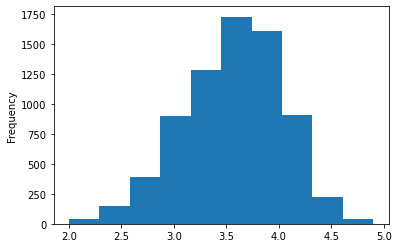

In [40]:
df_zom['rating'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

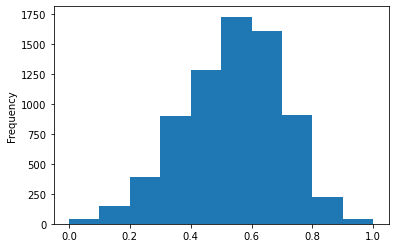

In [41]:
df_input_scale['rating'].plot(kind='hist')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df_input_scale.drop(target_column, axis=1), df_input_scale[target_column], test_size=0.2, random_state=42)


 MAE 0.1259387844521473 
 MSE 0.025471817839728402 
 R2 0.8269735553149941 


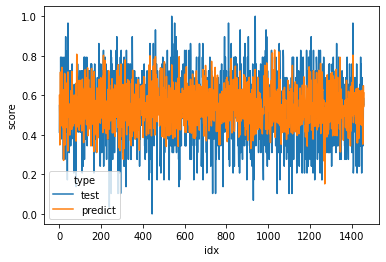

In [43]:
regr = RandomForestRegressor(random_state=0)
model_regr, y_pred_test_regr, y_pred_train_regr, result_rf   = model_perform(X_train, y_train, X_test, y_test, regr, name='rf', verbose =1 )
df_residual_rf = pd.DataFrame()
df_residual_rf['target'] = y_test
df_residual_rf['pred'] = y_pred_test_regr
df_residual_rf['error'] = df_residual_rf['target'] - df_residual_rf['pred']
df_residual_rf['std_error'] = (df_residual_rf['error'] - df_residual_rf['error'].mean()) / df_residual_rf['error'].std()

show_error_pattern(y_pred=y_pred_test_regr, y_test=y_test)

## Statistical regression analysis 

[Text(0.5, 1.0, 'correlation between error and predicted -0.23919447657229778')]

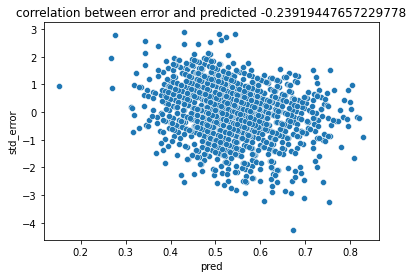

In [44]:
# examine predicted vs residual 
corr = stats.pearsonr(df_residual_rf['pred'],df_residual_rf['std_error'])[0]
sns.scatterplot(data=df_residual_rf, x="pred", y="std_error").set(title='correlation between error and predicted {}'.format(corr)) 

[Text(0.5, 1.0, 'coreelation between actual and predicted 0.32681121871937013')]

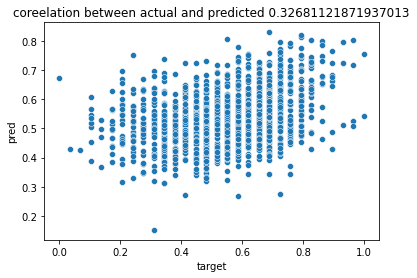

In [45]:
# correlation 
corr = stats.pearsonr(df_residual_rf['target'],df_residual_rf['pred'])[0]
sns.scatterplot(data=df_residual_rf, x="target", y="pred").set(title='coreelation between actual and predicted {}'.format(corr)) 

<AxesSubplot:title={'center':'error skewness from random forest -0.345'}, ylabel='Frequency'>

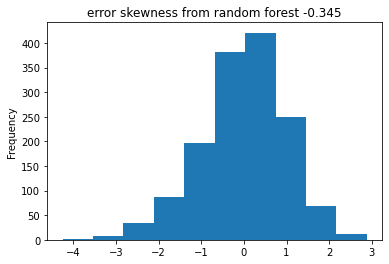

In [46]:
# plot error skewness 
title = 'error skewness from random forest {}'.format(np.round(skew(df_residual_rf['std_error']),3))
df_residual_rf['std_error'].plot(kind='hist', title = title)